In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np

# False Positives - Centroid Motion

This notebook continues with the mini-series on how to look for false positives in TESS data by lookin at centroid motions!

Notes:

- You need to run each cell. Do this by either pressing the 'run' button at the top of the page or pressing shift+enter (this is what Nora does in the videos). 

- When you run a cell, a star will appear in the brackets to the left of the cell while the cell is runnning. Once it has successfully completed running the code the star will turn into a number (often it runs so fast that you don't see the star).

- Text following a #, or within triple quotation marks (''') is ignored by the code (except in this cell because I made this into a text cell)


<IPython.core.display.Javascript object>


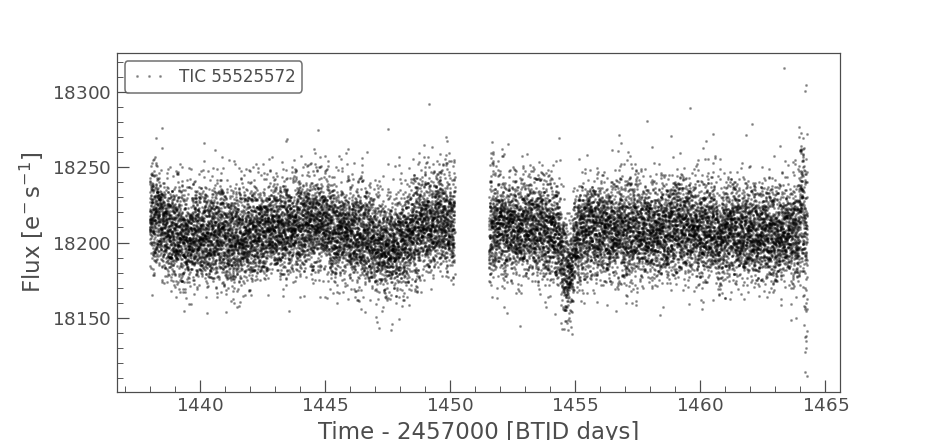

In [2]:
# download the TESS target pixel file
TIC = 'TIC 55525572' # CHANGE THIS to run for a differen target

'''
(this is a comment and not code - for longer comments you can use tripple quotation marks)

note, you need to know what sector the target was observed in. To Get a list of all
of the sectors run the following line of code (i.e. copy and paste it outside of these triple quotation marks): 

print (lk.search_lightcurve(TIC, author = 'SPOC'))

this will print the available sectors for a given target for you. 

'''
# CHANGE THE Sector for different targets
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 5) # CHANGE THE Sector for different targets

lc = sector_data.download()

lc.plot(linewidth = 0, marker = '.', color = 'black', alpha = 0.3)

Now that we've seen the lightcurve, let's try plotting the centroid motions. 

Previously when we plotted things, we used the 'lc.plot', however that only plots the lightcurve.

If we have downloaded the data using lightkurve and stored it in a paramater called 'lc' (as we did in the above cell), we can access various data like this: 

- **lc.time.value** - for the list of times of the observations 
- **lc.mom_centr1.value** - for the list of Brightness motion in the column direction
- **lc.pos_corr1.value** - for the list of Satellite motion in the column direction
- **lc.mom_centr2.value** - for the list of Brightness motion in the row direction
- **lc.pos_corr2.value** - for the list of Satellite motion in the row direction
      
    
the '.value' turns it into a format that we can use to plot it.


In [3]:
# bin the data (watch previous episode on binning)
lc_bin = lc.bin(7/60/24)

# set up the plotting region
fig, ax = plt.subplots(2,1, figsize = (8,5), sharex= True)

# plot the two different centroid motions in the column and row positions
ax[0].plot(lc_bin.time.value, lc_bin.mom_centr1.value-np.nanmean(lc_bin.mom_centr1.value), color = 'black', lw = 0, marker = '.', ms = 1)
ax[0].plot(lc_bin.time.value, lc_bin.pos_corr1.value-np.nanmean(lc_bin.pos_corr1.value), color = 'red', lw = 0, marker = '.', ms = 1)

ax[1].plot(lc_bin.time.value, lc_bin.mom_centr2.value - np.nanmedian(lc_bin.mom_centr2.value), color = 'black', lw = 0, marker = '.', ms = 1, label = 'Brightness motion')
ax[1].plot(lc_bin.time.value, lc_bin.pos_corr2.value- np.nanmedian(lc_bin.pos_corr2.value), color = 'red', lw = 0, marker = '.', ms = 1, label = 'Satellite motion')

# define the axis labels
ax[0].set_ylabel("Column position")
ax[1].set_ylabel("Row position")
plt.xlabel("Time (TJD)")
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

The large scale variabily that we see here isn't a problem - we only care about what the centroid positions are doing on the time scales of the transit-like events. For a potential real canidates, we want the centroid positions to be smooth on around the time of the transit like events. 

In the cell below you fill find the plotting of the centroid tests defined as a 'function'. You don't need to edit the fucntion but make sure that you have run the cell. 

Once the function cell has been defined, you can plot the flux and centroid positions with just one line of code:

**plot_centroids(lc, transit_time, window)**

where **lc** is the data downloaded with LightKurve, **transit_time** is the time of the event, and **window** is the cut-out window around the target that you want to look at. I would usually go with around 2 days for the window. If you want to look at the entire lightcurve simple do don't enter a window or a transit event.


In [4]:
'''
This cell contains the 'function' that plots the pixel level lighcurve plot! 
You don't need to do anything with this code but you do have to RUN THIS CELL for the test to work! 
'''

def plot_centroids(lc, transit_time=None, window=None):
        
    # bin the data 
    lc_bin = lc.bin(7/60/24)
    
    # generate a mask so that we only see the times around the transit event
    if (window == None) or (transit_time == None):
        transit_mask = lc_bin.time.value > 0
    else:
        transit_mask = (lc_bin.time.value > transit_time - window) & (lc_bin.time.value < transit_time + window)
        
    # make a plot with three panels so that we can see the lightcurve and the centroid positions 
    fig, ax = plt.subplots(3,1, figsize = (8,5), sharex= True)
    
    # plot the lightcurve in the top panel (in orange) 
    ax[0].plot(lc_bin.time.value[transit_mask], lc_bin.sap_flux.value[transit_mask], color = 'darkorange', lw = 0, marker = '.', ms = 3)
    
    # plot the centroid motions in the column direction in the middle panel
    ax[1].plot(lc_bin.time.value[transit_mask], lc_bin.mom_centr1.value[transit_mask]-np.nanmean(lc_bin.mom_centr1.value[transit_mask]), color = 'black', lw = 0, marker = '.', ms = 2, alpha = 0.5)
    ax[1].plot(lc_bin.time.value[transit_mask], lc_bin.pos_corr1.value[transit_mask]-np.nanmean(lc_bin.pos_corr1.value[transit_mask]), color = 'red', lw = 0, marker = '.', ms = 2, alpha = 0.5)
    
    # plot the centroid motions in the row direction in the middle panel
    ax[2].plot(lc_bin.time.value[transit_mask], lc_bin.mom_centr2.value[transit_mask] - np.nanmedian(lc_bin.mom_centr2.value[transit_mask]), color = 'black', lw = 0, marker = '.', ms = 2, alpha = 0.5, label = 'Brightness motion')
    ax[2].plot(lc_bin.time.value[transit_mask], lc_bin.pos_corr2.value[transit_mask]- np.nanmedian(lc_bin.pos_corr2.value[transit_mask]), color = 'red', lw = 0, marker = '.', ms = 2, alpha = 0.5, label = 'Satellite motion')
    
    if (transit_time != None):
        # draw a vertical line at the time of the transit event 
        ax[0].axvline(transit_time, color = 'grey', zorder = -1)
        ax[1].axvline(transit_time, color = 'grey', zorder = -1)
        ax[2].axvline(transit_time, color = 'grey', zorder = -1)
    
    # label the axes
    ax[0].set_ylabel("Flux")
    ax[1].set_ylabel("Column position")
    ax[2].set_ylabel("Row position")
    plt.xlabel("Time (TJD)")
    
    if (window != None) and (transit_time != None):   
        plt.xlim(transit_time - window, transit_time + window)
        
    plt.tight_layout()
    plt.legend()
    plt.show()

In [5]:
'''we can now use the function that was defined above to plot the test for a given target
(we'll start with the target that we already downlaoded data for above)

For the code to work all we need to do is define the time of the transit event and the size of the cut-out window.

If you want to look at the whole sector, simply don't enter a window at all (example to follow below)
'''

# define the transit time: 
transit_time = 1454.7 # CHANGE THIS for different targets !!! time of transit event

# and the cut out region 
window = 2 # let's look at the two days surrounding the target 

plot_centroids(lc, transit_time, window=window)

<IPython.core.display.Javascript object>

The centroid positions are looking nice and smooth in this example - which is exactly what we want!

Now let's look at soem false positives...

The code below cuts out some of the steps that we went through for the previous example to get to that final plot a little bit quicker. **You can use the code below (or above!) for any target by simply changing the TIC ID, the sector that you want to look at (look at one sector at a time for this analysis), the time of the transit event and (sometimes) the size of the cutout region.**

The three examples below are ALL examples of false positives.

<IPython.core.display.Javascript object>


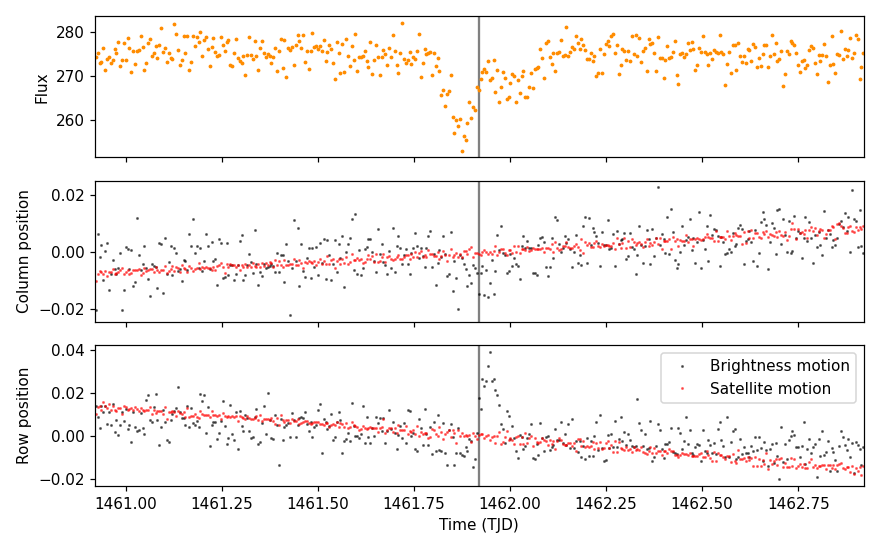

In [6]:
# example of a background event that can be seen in the centroid positions 

# defie the TIC ID

TIC = 'TIC 408000326' # !! CHANGE THIS for other targets

# search what SPOC data is available for a given target - and chose a sector (in example this is sector 5)

# To find out what sector a target was observed in delete the hashtag infront of the line of code directly below
#print (lk.search_lightcurve(TIC, author = 'SPOC') 

sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector =5) # !! CHANGE sector for a different target
lc = sector_data.download()

#to plot the data to find out the time of the transit event run this line: 
#lc.plot(linewidth = 0, marker = '.', color = 'black', alpha = 0.3)

# define the transit time and cut-out window 
transit_time = 1461.92 # !! CHANGE THIS define a transit time
# and the cut out region 
window = 1 # let's look at the two days surroudnign the target 

plot_centroids(lc, transit_time, window=window)

In [7]:
# example of a background event that can be seen in the centroid positions 
# NOTE in this example we are not creating a mask - we're going to look at the centroid position across the entire sector

TIC = 'TIC 450109281' # CHANGE THIS for different target

# search what SPOC data is available for a given target - and chose a sector (in example this is sector 5)
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 5)
lc = sector_data.download()


# lets looks at the entire sector for this target! In that case we don't need to enter a transit time or a window size
plot_centroids(lc)


<IPython.core.display.Javascript object>

In [8]:
# example of a systematisc event that can be seen in the centroid positions 

TIC = 'TIC 467341330'

# search what SPOC data is available for a given target - and chose a sector (in example this is sector 5)
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 10)

lc = sector_data.download()


# lets looks at the entire sector for this target! In that case we don't need to enter a transit time or a window size
# if you want to draw a line at a specific point you can still enter that...
plot_centroids(lc, transit_time = 1580)


<IPython.core.display.Javascript object>

In the above example you can see increased scatter in the centroid motion at the same times as you see 'dip-like' features in the lightcurve. We see the increased scatter in the red centroid - indicating that the satellite moved slightly at those times, whcih affected this lightcurve.

In [9]:
# example of another eclipsing binary
TIC = 'TIC 152362660'

# search what SPOC data is available for a given target - and chose a sector (in example this is sector 5)
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 5)
lc = sector_data.download()

# lets looks at the entire sector for this target! In that case we don't need to enter a transit time or a window size
# if you want to draw a line at a specific point you can still enter that...
plot_centroids(lc)


<IPython.core.display.Javascript object>

In [10]:
# If you want to investigate an event you found in a lightcurve, I would suggest usign this template: 
# note that the below cell won't run unless you fill in the cells where indicated

In [ ]:
# example of a background event that can be seen in the centroid positions 

TIC =  ???   #!! ENTER A TIC ID HERE

# search what SPOC data is available for a given target 
print (lk.search_lightcurve(TIC, author = 'SPOC') 


In [ ]:
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = ???) # !! ENTER THE SECTOR HERE
lc = sector_data.download()

# plot the data to find out the time of the transit-like event (if you don't already know it)
lc.plot(linewidth = 0, marker = '.', color = 'black', alpha = 0.3)


In [ ]:
# define the transit time and cut-out window 
transit_time =  ??? # !! CHANGE THIS define a transit time
# and the cut out region 
window = ???  # let's look at the two days surroudnign the target 

plot_centroids(lc, transit_time, window=window)